In [1]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.common import BarData

import threading, time
import pandas as pd
import matplotlib.pyplot as plt

class IBApp(EWrapper, EClient):
    def __init__(self):
        EWrapper.__init__(self)
        EClient.__init__(self, wrapper=self)
        self.data = []
        self.data_ready = threading.Event()
        self.connection_ready = threading.Event()

    def nextValidId(self, orderId):
        print(f"Connected (Order ID: {orderId})")
        self.connection_ready.set()

    # Fetch historical data
    def getData(self, contract, settings, req_id=1):
        if not self.isConnected():
            raise ConnectionError("Not connected to TWS or IB Gateway.")
        
        # Clear data and ready status
        self.data.clear()
        self.data_ready.clear()
        
        # Request data and wait for receipt
        self.reqHistoricalData(req_id, contract, **settings)
        self.data_ready.wait()
    
        # Create and Return Data in a Pandas DataFrame
        df = pd.DataFrame(self.data, columns=["Date", "Open", "High", "Low", "Close"])
        df["Date"] = pd.to_datetime(df["Date"])
        
        return df.set_index("Date")

    def historicalData(self, reqId, bar: BarData):
        self.data.append([bar.date, bar.open, bar.high, bar.low, bar.close])

    def historicalDataEnd(self, reqId, start, end):
        self.data_ready.set()

    ''' User Defined Methods '''
    ''' -------------------- '''
    
    # User method - Define a contract - Defaulting to USD Stocks for Easy Input
    def createContract(self, symbol, sec_type="STK", exchange="SMART", currency="USD"):
        c = Contract()
        c.symbol, c.secType, c.exchange, c.currency = symbol, sec_type, exchange, currency
        return c

    # User method - Define historical data parameters and return as a dictionary object
    def dataSettings(self, durationStr, barSizeSetting,
                     endDateTime='', whatToShow='TRADES', useRTH=1,
                     formatDate=1, keepUpToDate=False, chartOptions=[]):
        return {
            'endDateTime': endDateTime,
            'durationStr': durationStr,
            'barSizeSetting': barSizeSetting,
            'whatToShow': whatToShow,
            'useRTH': useRTH,
            'formatDate': formatDate,
            'keepUpToDate': keepUpToDate,
            'chartOptions': chartOptions
        }
    
    # User method - Display market data
    def displayData(self, df, rows=5):
        """Print the last `rows` of the DataFrame, or all if `rows` is None."""
        print(df if rows is None else df.tail(rows))

    # User method - Plot market data
    def plotData(self, df, title="Price Chart"):
        df["Close"].plot(title=title)
        plt.tight_layout()
        plt.show()

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Connected (Order ID: 1)
                Open      High       Low     Close
Date                                              
2025-07-28  119310.0  119450.0  119310.0  119320.0
2025-07-29  119400.0  119400.0  119320.0  119370.0
2025-07-30  119380.0  119420.0  119350.0  119400.0
2025-07-31  119400.0  119440.0  119380.0  119390.0
2025-08-01  119420.0  119560.0  119380.0  119560.0


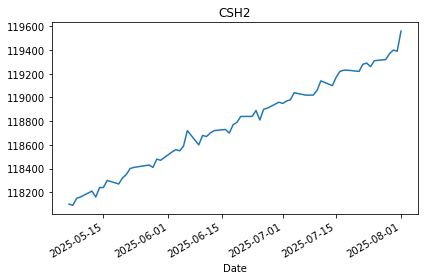

ERROR 1 2176 Warning: Your API version does not support fractional share size rules. Please upgrade to a minimum version 163. Trimmed value 380795.57 to 380795


              Open    High     Low   Close
Date                                      
2025-07-28  214.00  214.85  213.06  214.05
2025-07-29  214.16  214.81  210.89  211.27
2025-07-30  211.90  212.39  207.72  209.05
2025-07-31  208.49  209.84  207.16  207.57
2025-08-01  210.95  213.58  201.50  202.38


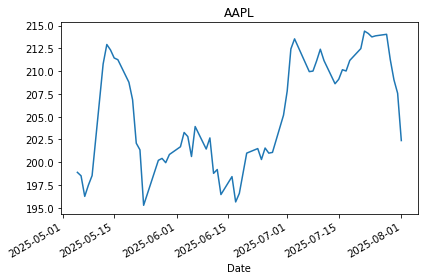

              Open    High     Low   Close
Date                                      
2025-07-28  174.01  176.98  173.97  176.75
2025-07-29  178.00  179.38  175.02  175.51
2025-07-30  176.51  179.89  176.04  179.27
2025-07-31  182.90  183.30  175.93  177.87
2025-08-01  174.12  176.54  170.89  173.72


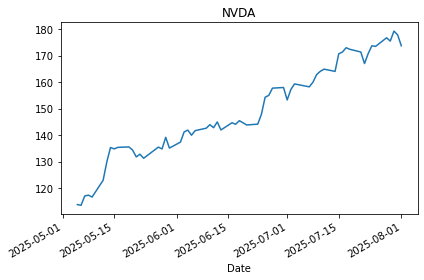

In [2]:
''' Demo Usage '''
''' ---------- '''

def run():
    app = IBApp()
    app.connect('127.0.0.1', 7497, clientId=1)

    # Start IB event loop in background
    thread = threading.Thread(target=app.run, daemon=True)
    thread.start()

    app.connection_ready.wait()

    ''' User Configuration '''
    ''' ------------------ '''
    
    # Single Stock
    # ------------
    symbol1 = "CSH2"
    contract1 = app.createContract(symbol1, "STK", "LSE", "GBP")
    settings1 = app.dataSettings("3 M", "1 day", whatToShow="TRADES")
    
    df1 = app.getData(contract1, settings1)
    app.displayData(df1)
    app.plotData(df1, title=symbol1)

    # Multiple Stocks
    # ---------------
    stocks = ["AAPL", "NVDA"]
    settings = app.dataSettings("3 M", "1 day", whatToShow="TRADES")  # whatToShow: TRADES, BID, ASK, MIDPOINT, etc.

    for symbol in stocks:
        contract = app.createContract(symbol)
        df = app.getData(contract, settings)
        app.displayData(df)
        app.plotData(df, title=f"{symbol}")
 
    # Disconnect cleanly using thread.join() to wait for background thread to finish
    app.disconnect()
    thread.join()

if __name__ == "__main__":
    run()